In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

2025-05-20 02:13:10.779055: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-20 02:13:11.089408: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-20 02:13:11.226538: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-20 02:13:11.264094: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-20 02:13:11.504483: I tensorflow/core/platform/cpu_feature_guar

# CNN전이학습_data_augmentation
* 전이학습: 사전에 훈련된 모델을 가져와서 사용하는 것
* data_agmentation: 이미지 데이터의 경우 데이터가 적어서 확보가 어려움, 비쌈, 기존 이미지데이터에 변형을 가해서 데이터 수를 늘리는 작업(회전, 확대, 축소, 자르기)

## Image Augmentation
* 학습데이터 부족을 해결하기 위해서 이미지에 변형을 가해 새로운 이미지를 만들어 주는 것

In [58]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img

In [59]:
image = load_img("./data/catanddog/bird.jpg")
image_array = img_to_array(image)
image_array.shape

(703, 454, 3)

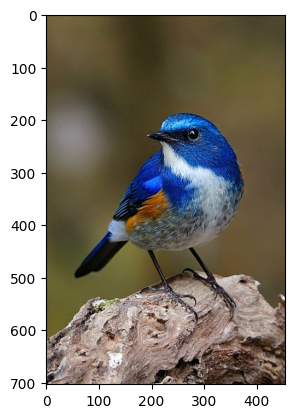

In [60]:
plt.imshow(image)
plt.show()

# Image Augmentation(이미지증폭)

In [61]:
imggen = ImageDataGenerator(
    rescale=1./225,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode="nearest")

In [62]:
image_array.shape

(703, 454, 3)

2.차원늘리기

In [5]:
image_array.reshape((1, )+ image_array.shape).shape

(1, 703, 454, 3)

In [63]:
image_array = image_array.reshape((1, )+ image_array.shape)
image_array.shape

(1, 703, 454, 3)

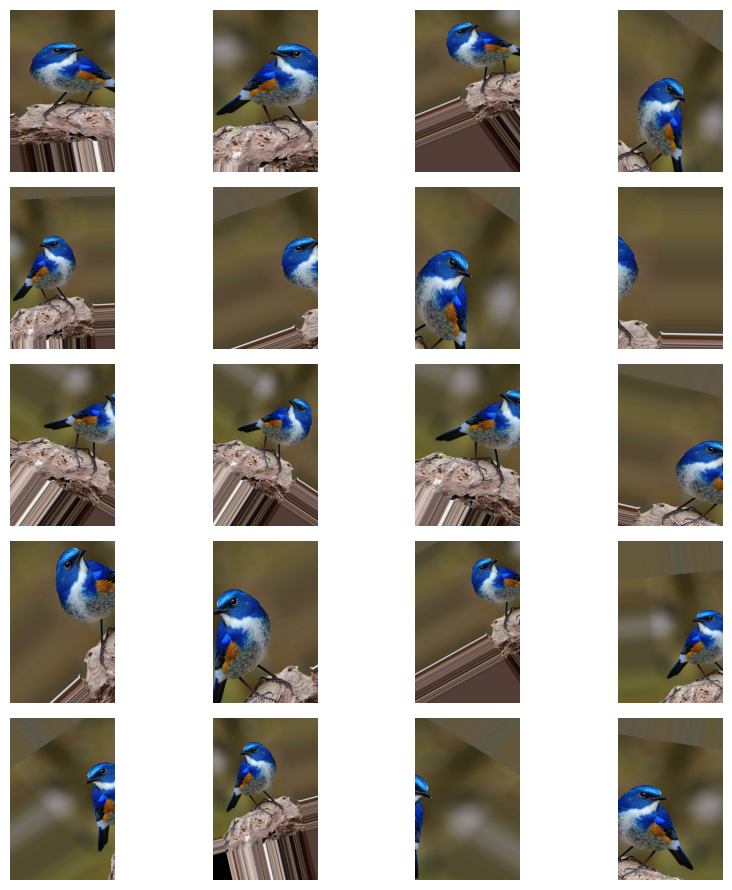

In [65]:
fig, axes = plt.subplots(5,4, figsize=(9,9))
axes = axes.ravel()

for i, batch in enumerate(imggen.flow(image_array, batch_size=1)):
    if i >= 20:
        break
    augmented_image = array_to_img(batch[0])
    axes[i].imshow(augmented_image)
    axes[i].axis('off')
plt.tight_layout()
plt.show()

# image_augemtation을 이용한 개/고양이 분류모델 만들기


In [67]:
# 데이터 로드
train_dir = "./data/catanddog/train/"
valid_dir = "./data/catanddog/validation/"
batch_size = 16 # 한 번에 불러오는 사진의 개수, 분석 모델에 따라서 16(큼)~32(작음) 사이로 지정
image_size= (224,224) # 모델의 입력 크기에 맞춤

In [23]:
# 이미지 증강
train_aug = ImageDataGenerator(
    rescale=1./225,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.2,
    shear_range=0.6,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode="nearest")

valid_aug = ImageDataGenerator(rescale=1./255)

# 이미지 제너레이터
train_gen = train_aug.flow_from_directory(
    train_dir,
    target_size = image_size,
    batch_size =  batch_size,
    class_mode = 'categorical',
    shuffle=True,
    seed=42)

valid_gen = valid_aug.flow_from_directory(
    valid_dir,
    target_size = image_size,
    batch_size =  batch_size,
    class_mode = 'categorical',
    shuffle=True,
    seed=42)

X_batch, y_batch = next(train_gen)
print(X_batch.shape)
print(y_batch.shape)
print(train_gen.class_indices)

Found 2222 images belonging to 2 classes.
Found 98 images belonging to 2 classes.
(16, 224, 224, 3)
(16, 2)
{'Cat': 0, 'Dog': 1}


# CNN을 이용한 개 /고양이 분류

In [9]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [27]:
cnn_model = Sequential()
cnn_model.add(Input(shape=(224,224,3)))
cnn_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Flatten())

cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.2))  # 0.2는 과적합 방지용 적절한 값입니다
cnn_model.add(Dense(128, activation='relu'))

# 출력층: 이진 분류 (cat vs dog)
cnn_model.add(Dense(2, activation='softmax'))
cnn_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 107, 107, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 51, 51, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 20000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     2,560,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,651,682 (10.12 MB)

 Trainable params: 2,651,682 (10.12 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
import tensorflow as tf

In [37]:
cnn_model.compile(loss="categorical_crossentropy", 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                 metrics=['accuracy'])
model_path = "./model/cnn_catanddog.keras"
check_point = ModelCheckpoint(model_path, save_best_only=True, monitor="val_loss", verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True )
cnn_history = cnn_model.fit(train_gen)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1747721486.270074     124 service.cc:146] XLA service 0x1d16c8c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747721486.271602     124 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce MX450, Compute Capability 7.5
2025-05-20 06:11:27.687187: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-20 06:11:34.648292: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8906
2025-05-20 06:11:55.301008: E ext

  1/139 ━━━━━━━━━━━━━━━━━━━━ 2:51:03 74s/step - accuracy: 0.5625 - loss: 0.6914

I0000 00:00:1747721534.803911     124 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


124/139 ━━━━━━━━━━━━━━━━━━━━ 7s 467ms/step - accuracy: 0.5142 - loss: 0.6983

E0000 00:00:1747721596.428683     125 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747721596.703742     125 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747721597.891231     125 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747721598.142438     125 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747721598.409278     125 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-

139/139 ━━━━━━━━━━━━━━━━━━━━ 154s 576ms/step - accuracy: 0.5146 - loss: 0.6977


In [38]:
# best 모델 로드
cnn_best_model = load_model("./model/cnn_catanddog.keras")

#클래스 이름 출력하기
class_indices = valid_gen.class_indices
class_names = [k for k, v in sorted(class_indices.items(), key=lambda x: x[1])]
validation_batch, label_batch = next(iter(valid_gen))

cnn_pred =  cnn_best_model.predict(valid_batch)
pred_values = np.argmax(cnn_pred, axis=1)
true_values = np.argmax(label_batch, axis=1)

fig = plt.figure(figsize=(12,12))
fig.subplots_adjust(hspace=0.3)

num_images = min(16,validation_batch_shape[0])

for i in range(num_images):
    ax = fig.add_subplot(4,4, i +1, xticks=[], yticks=[] )
    ax.imshow(validation_batch[i], cmap=plt.cm.gray_r)
    
    pred_label = class_name[pred_values[i] ]
    true_label =  class_names[true_values[i]]
    color = 'green' if pred_values[i] == true_values[i] else 'red'
    ax.set_title(f"Pred: {pred_label}", color=color, fontsize= 12)
plt.show()

ValueError: File not found: filepath=./model/cnn_catanddog.keras. Please ensure the file is an accessible `.keras` zip file.

# keras 홈페이지 
* 여기서 api 사용가능
* 숫자가 커지면 파라미터가 크다는 뜻

* https://keras.io/api/applications/
* https://ai.google.dev/edge/mediapipe/solutions/guide?hl=ko

# 전이 학습
* 사전에 훈련된 모델을 가지고 새로운 데이터를 넣어서 튜닝을 하거나 결과를 출력
* KERAS.APPLICATIONS에 있음

# ResNet50 

In [41]:
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50, ResNet152V2


In [42]:
base_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor = None,
    input_shape=(244,244,3),
    pooling='avg')

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


In [43]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 244, 244,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 250, 250,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 122, 122,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 122, 122,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 122, 122,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 124, 124,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 61, 61,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 61, 61,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 61, 61,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 61, 61,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 61, 61,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 61, 61,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 61, 61,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 61, 61,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 61, 61,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 61, 61,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 61, 61,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [45]:
base_model.trainable = False
res50_model = Sequential()
res50_model.add(base_model)
res50_model.add(Dense(2, activation='softmax'))

In [ ]:
res50_model.compile(loss="categorical_crossentropy", 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                 metrics=['accuracy'])
model_path = "./model/resnet50_catanddog.keras"
check_point = ModelCheckpoint(model_path, save_best_only=True, monitor="val_loss", verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True )
cnn_history = cnn_model.fit(train_gen)

# ResNet152V2

In [51]:
base_model2 = ResNet152V2(
    include_top = False,
    weights='imagenet',
    input_shape=(224,225,3),
    pooling='avg')


234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 22s 0us/step


In [52]:
base_model2.summary()

Model: "resnet152v2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 225,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 231,  │          0 │ input_layer_6[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 113,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 115,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 57,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 57,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 57,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 57,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 57,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 57,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 59,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 57,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 57,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 57,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 57,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 57,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 57,    │          0 │ conv2_block1_0_c

 Total params: 58,331,648 (222.52 MB)

 Trainable params: 58,187,904 (221.97 MB)

 Non-trainable params: 143,744 (561.50 KB)

In [53]:
base_model2.trainbale = False
res152v2_model = Sequential()
res152v2_model.add(base_model2)
res152v2_model.add(Dense(2, activation='softmax'))

In [54]:
res152v2_model.compile(loss="categorical_crossentropy", 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                 metrics=['accuracy'])
model_path = "./model/res152v2_catanddog.keras"
check_point = ModelCheckpoint(model_path, save_best_only=True, monitor="val_loss", verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, )
res152v2_history = res152v2_model.fit(train_gen, epochs=1000, validation_data=validation
                                            callback=[early_stop, check_point])
plt.plot(res152v2_history.history['loss'])
plt.plot(res152v2_history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.leggend(['train','vaild'])
plt.show()

SyntaxError: invalid syntax. Perhaps you forgot a comma? (1199462966.py, line 7)

# convnextbase로 분석하기

In [56]:
from tensorflow.keras.applications import ConvNeXtBase

In [57]:
base_model3 =  ConvNeXtBase(
    include_top=True,
    include_preprocessing=True,
    weights="imagenet",
    input_shape=(224,224,3),
    pooling='avg',
    classes=1000,
    classifier_activation="softmax",
    name="convnext_base",
)

355031056/355031056 ━━━━━━━━━━━━━━━━━━━━ 36s 0us/step


In [ ]:
base_model3.trainable = False
ConvNeXtBase_model = Sequential()
ConvNeXtBase_model.add(base_model)
ConvNeXtBase_model.add(Dense(2, activation='softmax'))

In [ ]:
ConvNeXtBase_model.compile(loss="categorical_crossentropy", 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                 metrics=['accuracy'])
model_path = "./model/ConvNeXtBase_model_catanddog.keras"
check_point = ModelCheckpoint(model_path, save_best_only=True, monitor="val_loss", verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, )
ConvNeXtBase_history = ConvNeXtBase_model.fit(train_gen, epochs=1000, validation_data=validation
                                            callback=[early_stop, check_point])
plt.plot(ConvNeXtBase_history.history['loss'])
plt.plot(ConvNeXtBase_history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.leggend(['train','vaild'])
plt.show()